0.00388577 -0.00549926


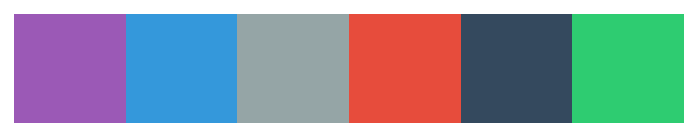

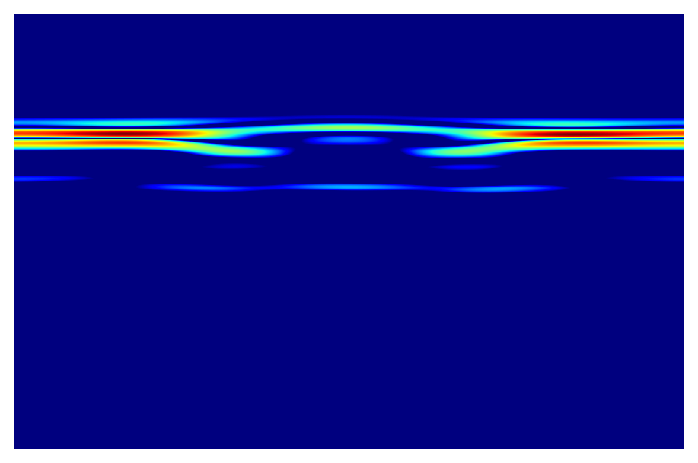

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"
import scipy.misc
from utils import imsave
import tensorflow as tf
import numpy as np
import time
import sys
import matplotlib as mpl
mpl.rcParams["axes.grid"] = False
mpl.rcParams["axes.facecolor"] = "#ededed"
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.bottom"] = False
from sar_utilities import to_dB, visualize_raw_data, get_spectrum, \
    visualize_raw_data_spectrum, insert_freq_gaps, \
    generate_raw_data_from_dict, downsample, snr, \
    add_gaussian_noise, preprocess_train, preprocess_test, \
    generate_raw_data
import scipy.io as sio

from cycler import cycler
import seaborn as sns
color_palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(color_palette)
mpl.rcParams["axes.prop_cycle"] = cycler('color', color_palette)
ori_color = color_palette[1]
corrupted_color = color_palette[0]
reconstructed_color = color_palette[5]

DATA_PATH = "/data/dung/sargan"
import os
float_type = np.float32
mat_file_name = "sar_dict_target_distance_5"
sar_dict_data = sio.loadmat(os.path.join(DATA_PATH, mat_file_name + ".mat"))
ori_n_apertures = int(sar_dict_data["n_apertures"][0][0])
ori_n_samples = int(sar_dict_data["n_samples"][0][0])
sar_dict_mat = sar_dict_data["sar_dict"].astype(float_type)
transmitted_pulse = sar_dict_data["pulse"].astype(float_type)
transmistted_pulse_sample_period = sar_dict_data["pulse_sampling_period"][0][0].astype(float_type)
sampling_period = transmistted_pulse_sample_period

real_data_filename = "real_sar_data/C1.mat"
real_data_file_path = os.path.join(DATA_PATH, real_data_filename)
real_mat_data = sio.loadmat(real_data_file_path)
real_raw_data = real_mat_data["Data"]
real_ori_n_samples, real_ori_n_apertures = real_raw_data.shape
calibrated_real_raw_data = np.vstack((np.zeros((300, real_ori_n_apertures)), real_raw_data, np.zeros((600, real_ori_n_apertures))))
print(np.max(real_raw_data), np.min(real_raw_data))
visualize_raw_data(real_raw_data)
n_fft = ori_n_samples
sampling_freq = 1. / (sampling_period)
df = sampling_freq / n_fft
freq = [df*i / 1e9 for i in range(0, n_fft)]    

In [101]:
n_fft

1500

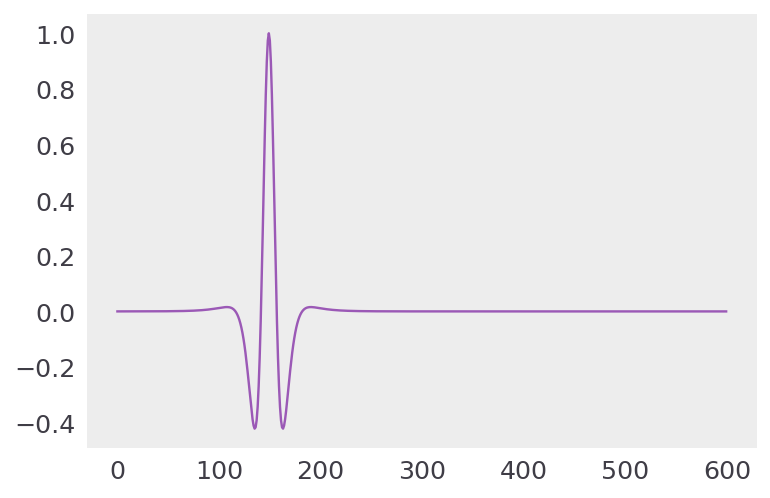

In [102]:
plt.plot(transmitted_pulse)

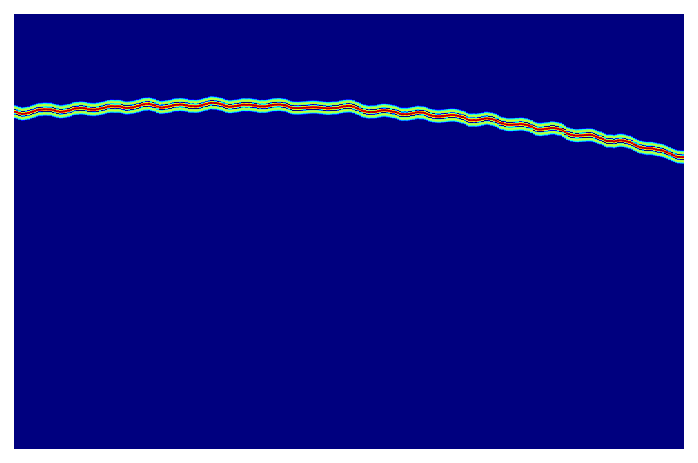

In [103]:
# Reshape dictionary to (1200, 300) and rescale to [-0.01, 0.01]
# sample_range = (150, 1350)
# aperture_range = (0, 300)
sample_range = (0, 1500)
aperture_range = (0, 301)
n_samples = sample_range[1] - sample_range[0]
n_apertures = aperture_range[1] - aperture_range[0]
magnitude_range = (-0.01, 0.01)
n_atoms = sar_dict_mat.shape[1]

downsample_factor = 1
n_samples = n_samples // downsample_factor
processed_sar_dict = np.empty([n_samples, n_apertures, n_atoms])
for i_atom in range(sar_dict_mat.shape[1]):
    atom_mat = np.reshape(sar_dict_mat[:, i_atom], (ori_n_samples, ori_n_apertures), order="F")
    atom_mat = atom_mat[sample_range[0]:sample_range[1], aperture_range[0]:aperture_range[1]]
    atom_mat = downsample(atom_mat, downsample_factor, 1)
    sampling_period *= downsample_factor
    processed_sar_dict[:, :, i_atom] = atom_mat
    
# processed_sar_dict *= magnitude_range[1] / np.max(processed_sar_dict)
reshaped_sar_dict_mat = processed_sar_dict.reshape(n_samples*n_apertures, n_atoms)
visualize_raw_data(reshaped_sar_dict_mat[:, 0].reshape(n_samples, n_apertures))

In [104]:
reshaped_sar_dict_mat.shape

(451500, 441)

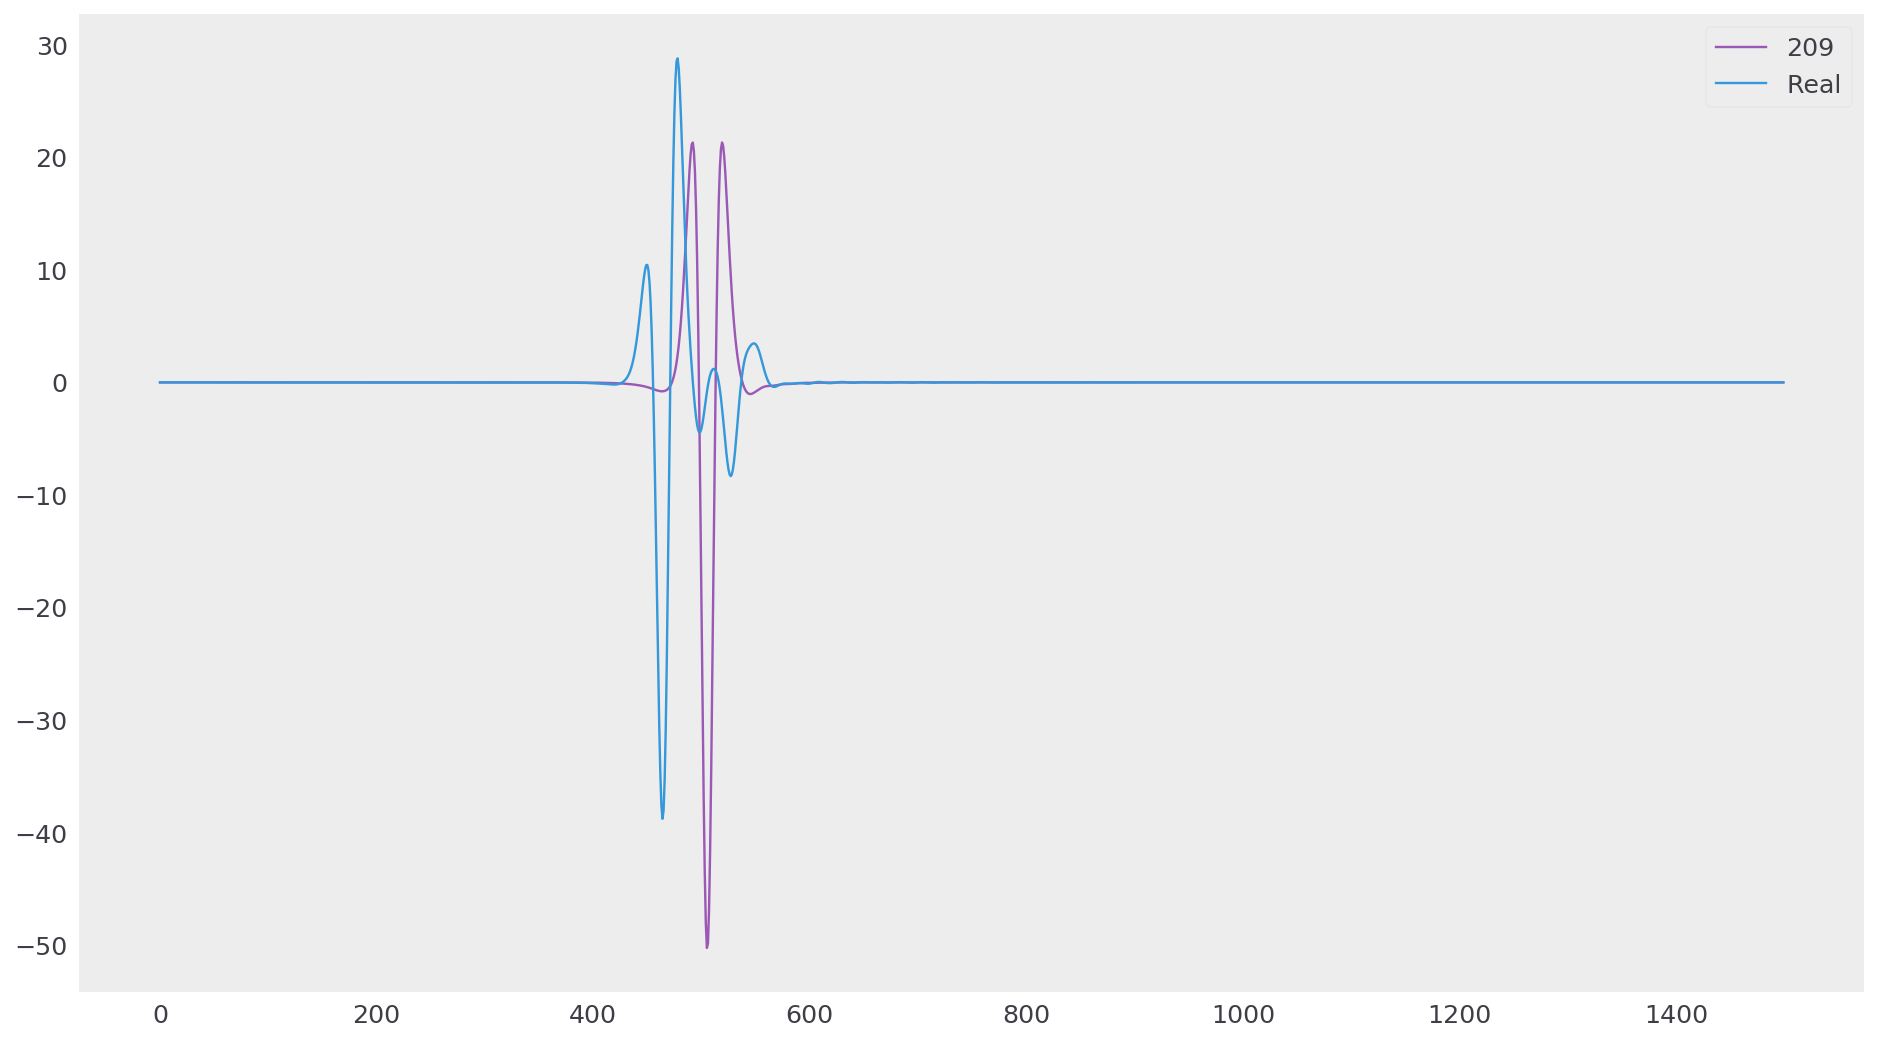

In [109]:
first_atom_mat = reshaped_sar_dict_mat[:, 5].reshape(n_samples, n_apertures)
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111);
# for i in range(n_apertures):
#     ax.plot(first_atom_mat[:, i])
# ax.plot(first_atom_mat[:, 0], label="0")
# ax.plot(first_atom_mat[:, 150], label="150")
ax.plot(first_atom_mat[:, 209], label="209")
# ax.plot(first_atom_mat[:, 250], label="250")
# ax.plot(first_atom_mat[:, 299], label="300")
ax.plot(1e4*calibrated_real_raw_data[:, 0], label="Real")
ax.legend()

(1500,)


Text(0.5,1,'Spectrum: real data')

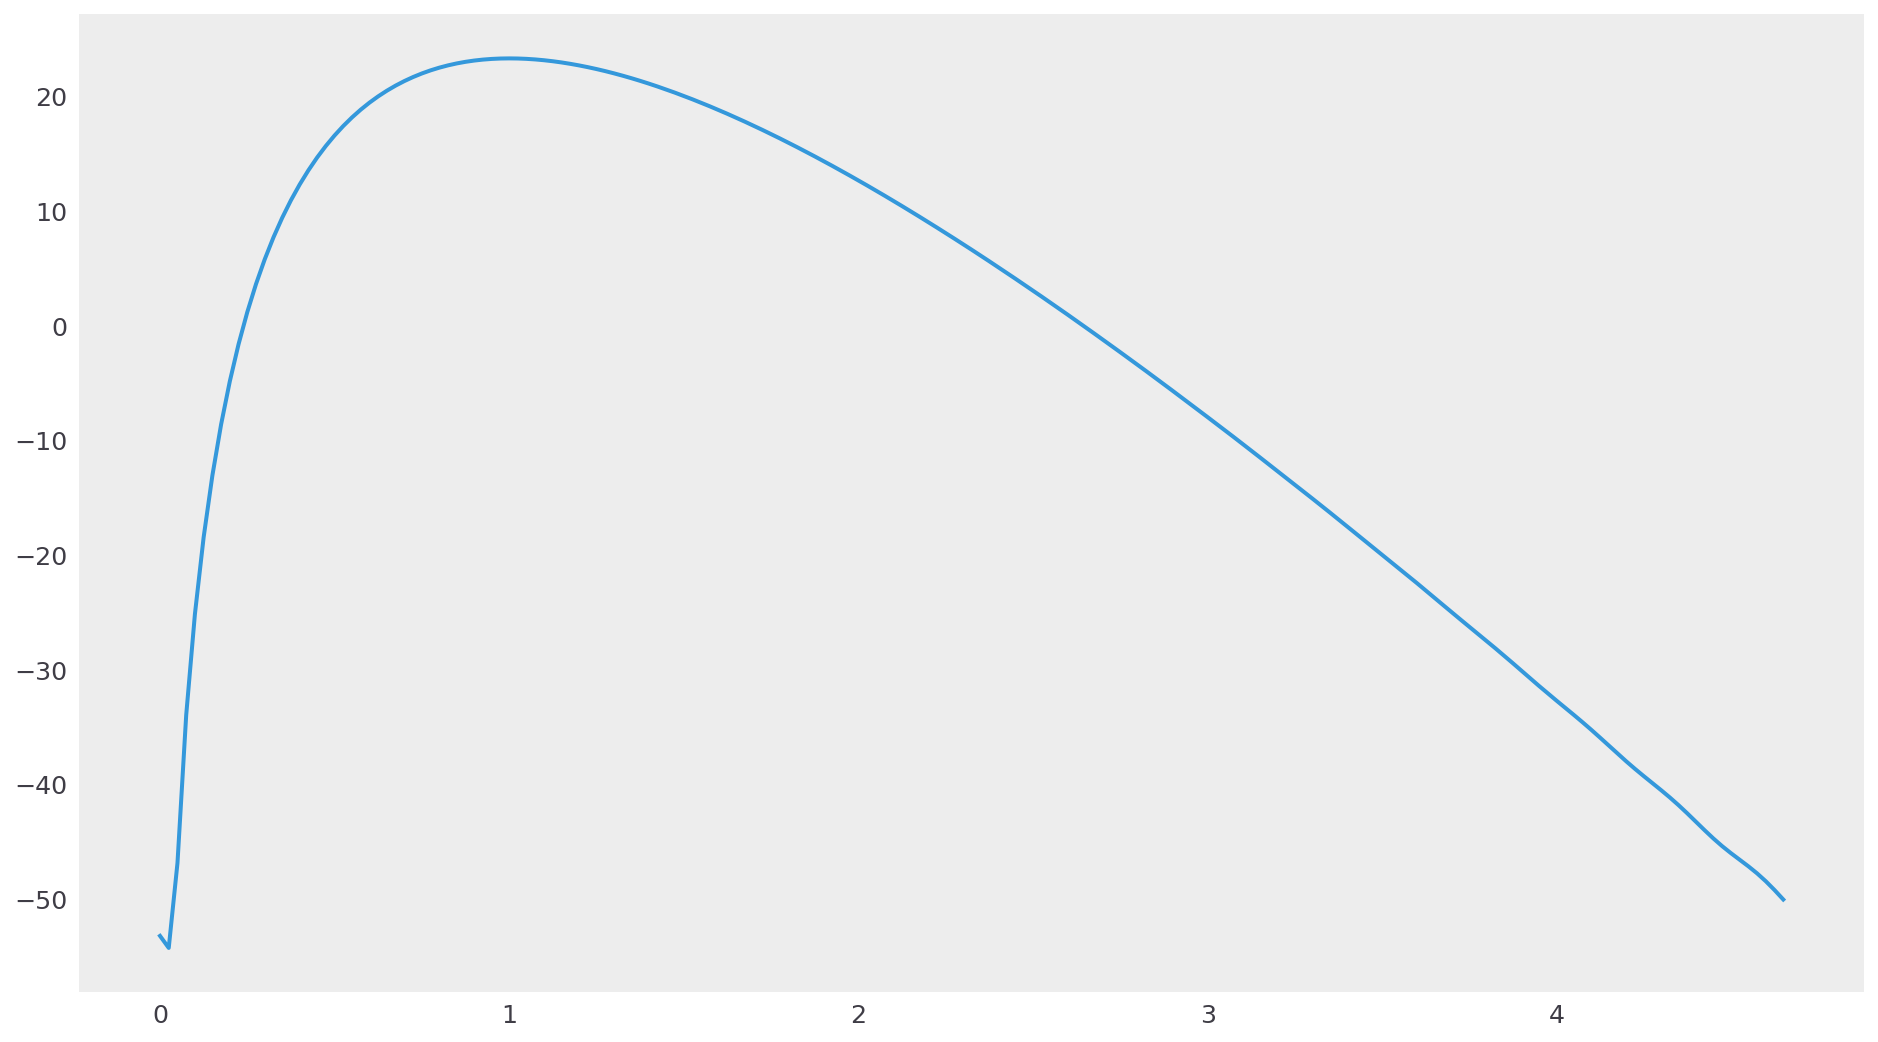

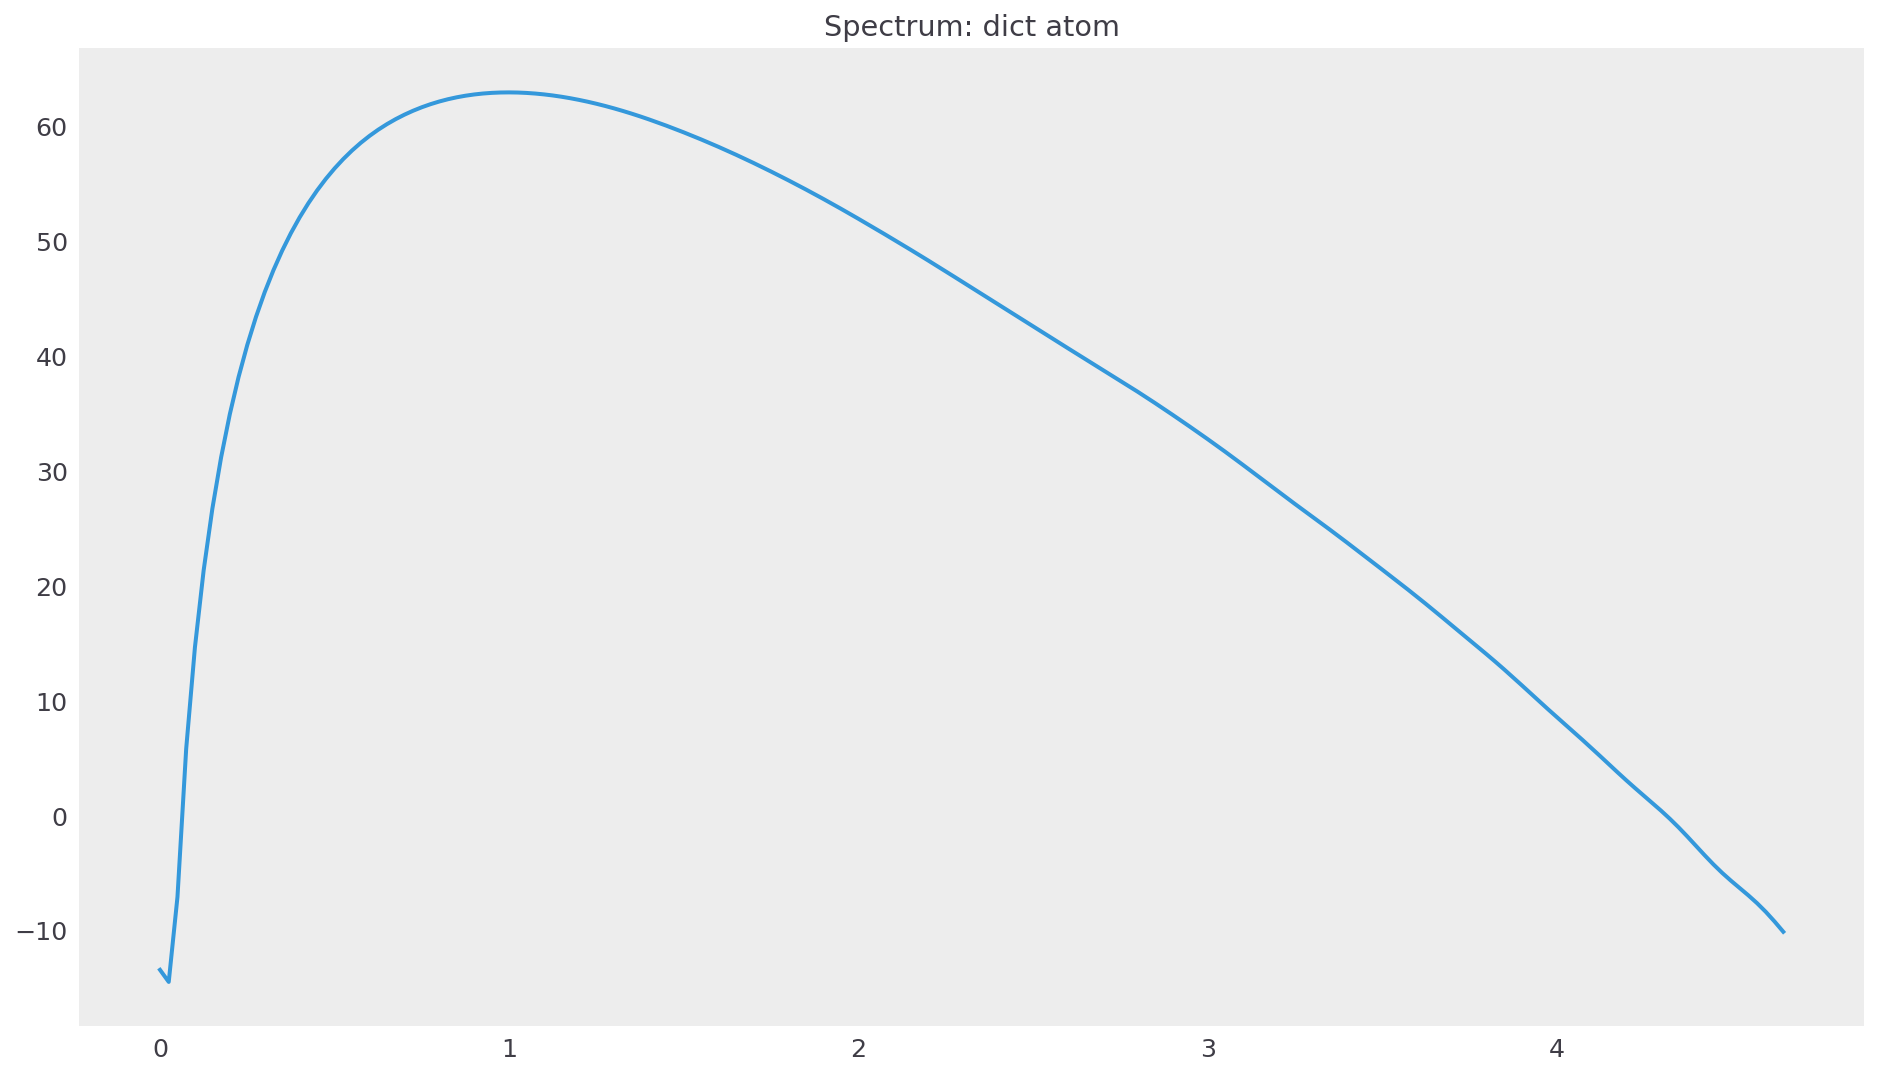

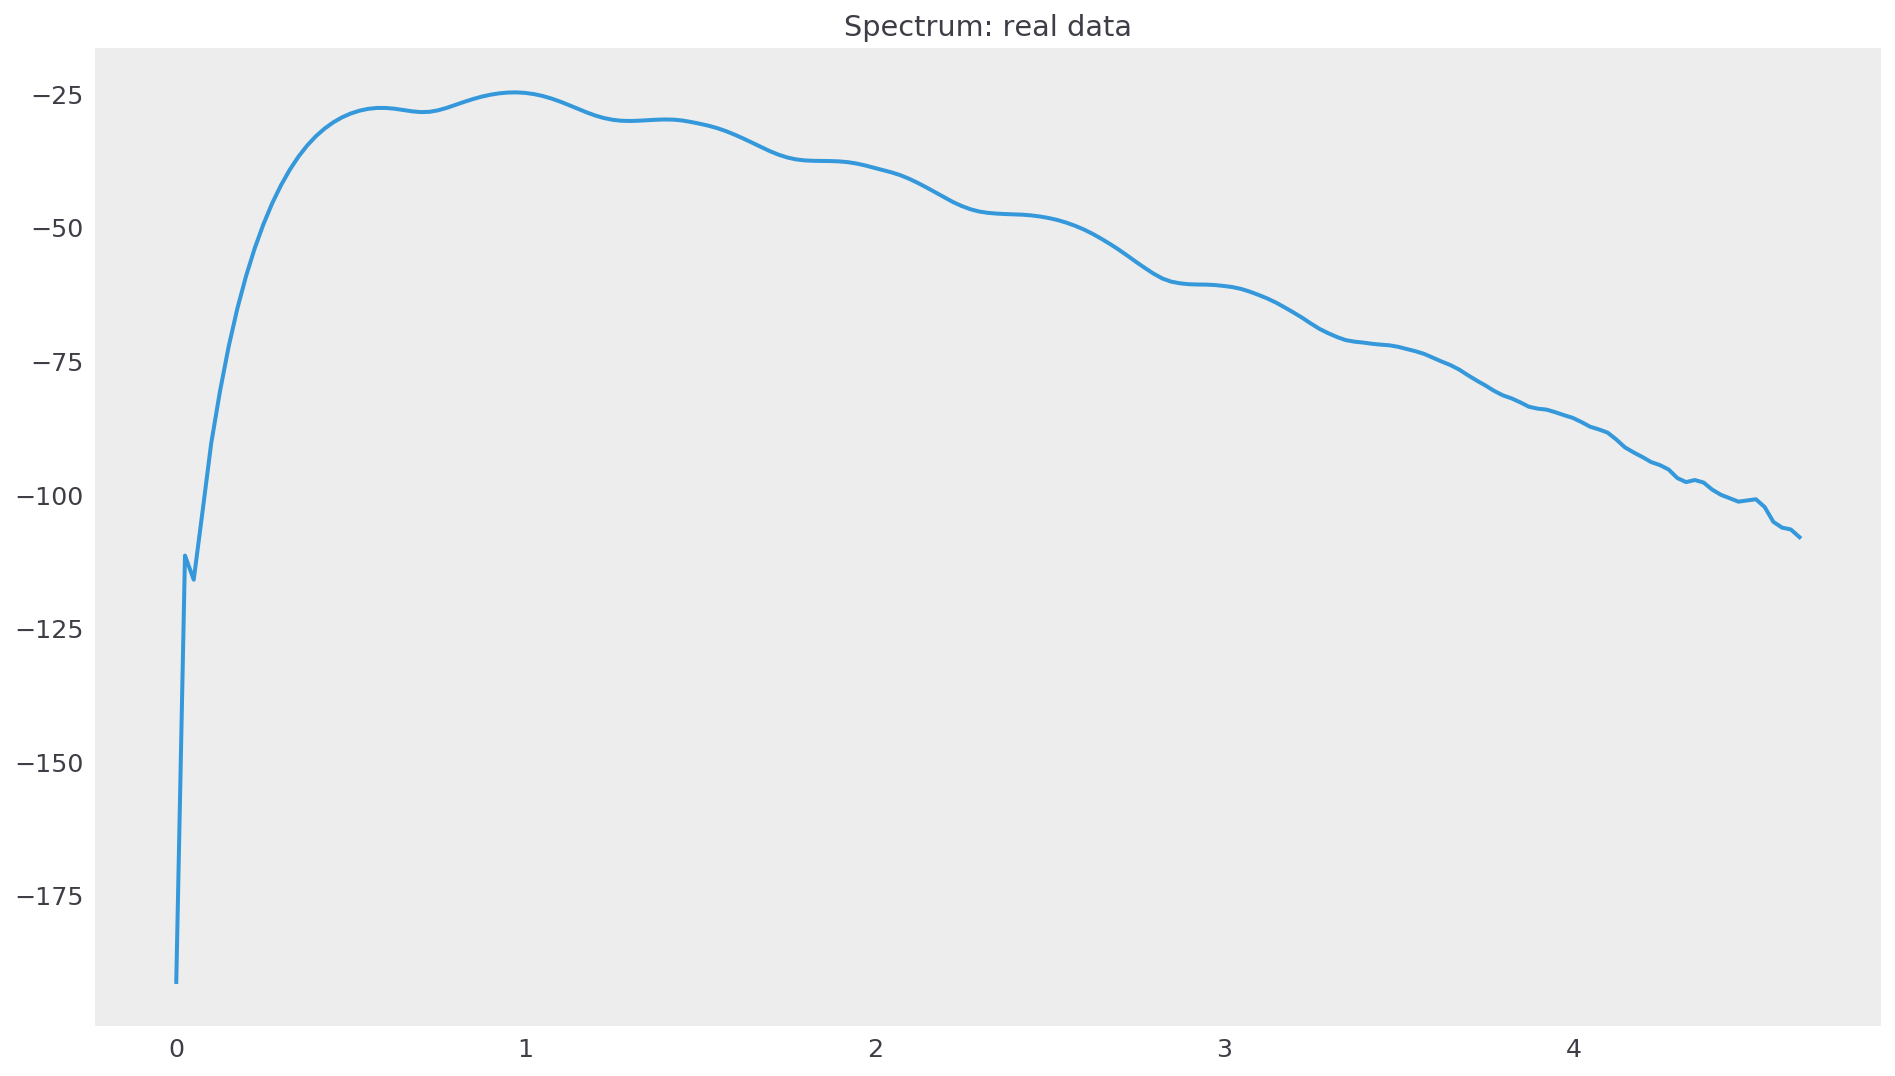

In [110]:
zoom_factor = 8
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111);
raw_spectrum = get_spectrum(transmitted_pulse, n_fft)
raw_spectrum_dB = to_dB(np.mean(raw_spectrum[0:n_fft//zoom_factor, :], axis=1))
ax.plot(freq[0:n_fft // zoom_factor], raw_spectrum_dB, color=ori_color, lw=2.0)

fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111);
# raw_spectrum = get_spectrum(first_atom_mat.reshape(ori_n_samples, ori_n_apertures), n_fft)
# raw_spectrum_dB = to_dB(np.mean(raw_spectrum[0:n_fft//zoom_factor, :], axis=1))
raw_spectrum = get_spectrum(first_atom_mat[:, 200], n_fft)
raw_spectrum_dB = to_dB(raw_spectrum)
print(raw_spectrum_dB.shape)
ax.plot(freq[0:n_fft // zoom_factor], raw_spectrum_dB[0:n_fft//zoom_factor], color=ori_color, lw=2.0)
ax.set_title("Spectrum: dict atom")

fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111);
raw_spectrum = get_spectrum(calibrated_real_raw_data, n_fft)
raw_spectrum_dB = to_dB(np.mean(raw_spectrum[0:n_fft//zoom_factor, :], axis=1))
ax.plot(freq[0:n_fft // zoom_factor], raw_spectrum_dB, color=ori_color, lw=2.0)
ax.set_title("Spectrum: real data")

In [67]:
raw_spectrum.shape

(1500,)

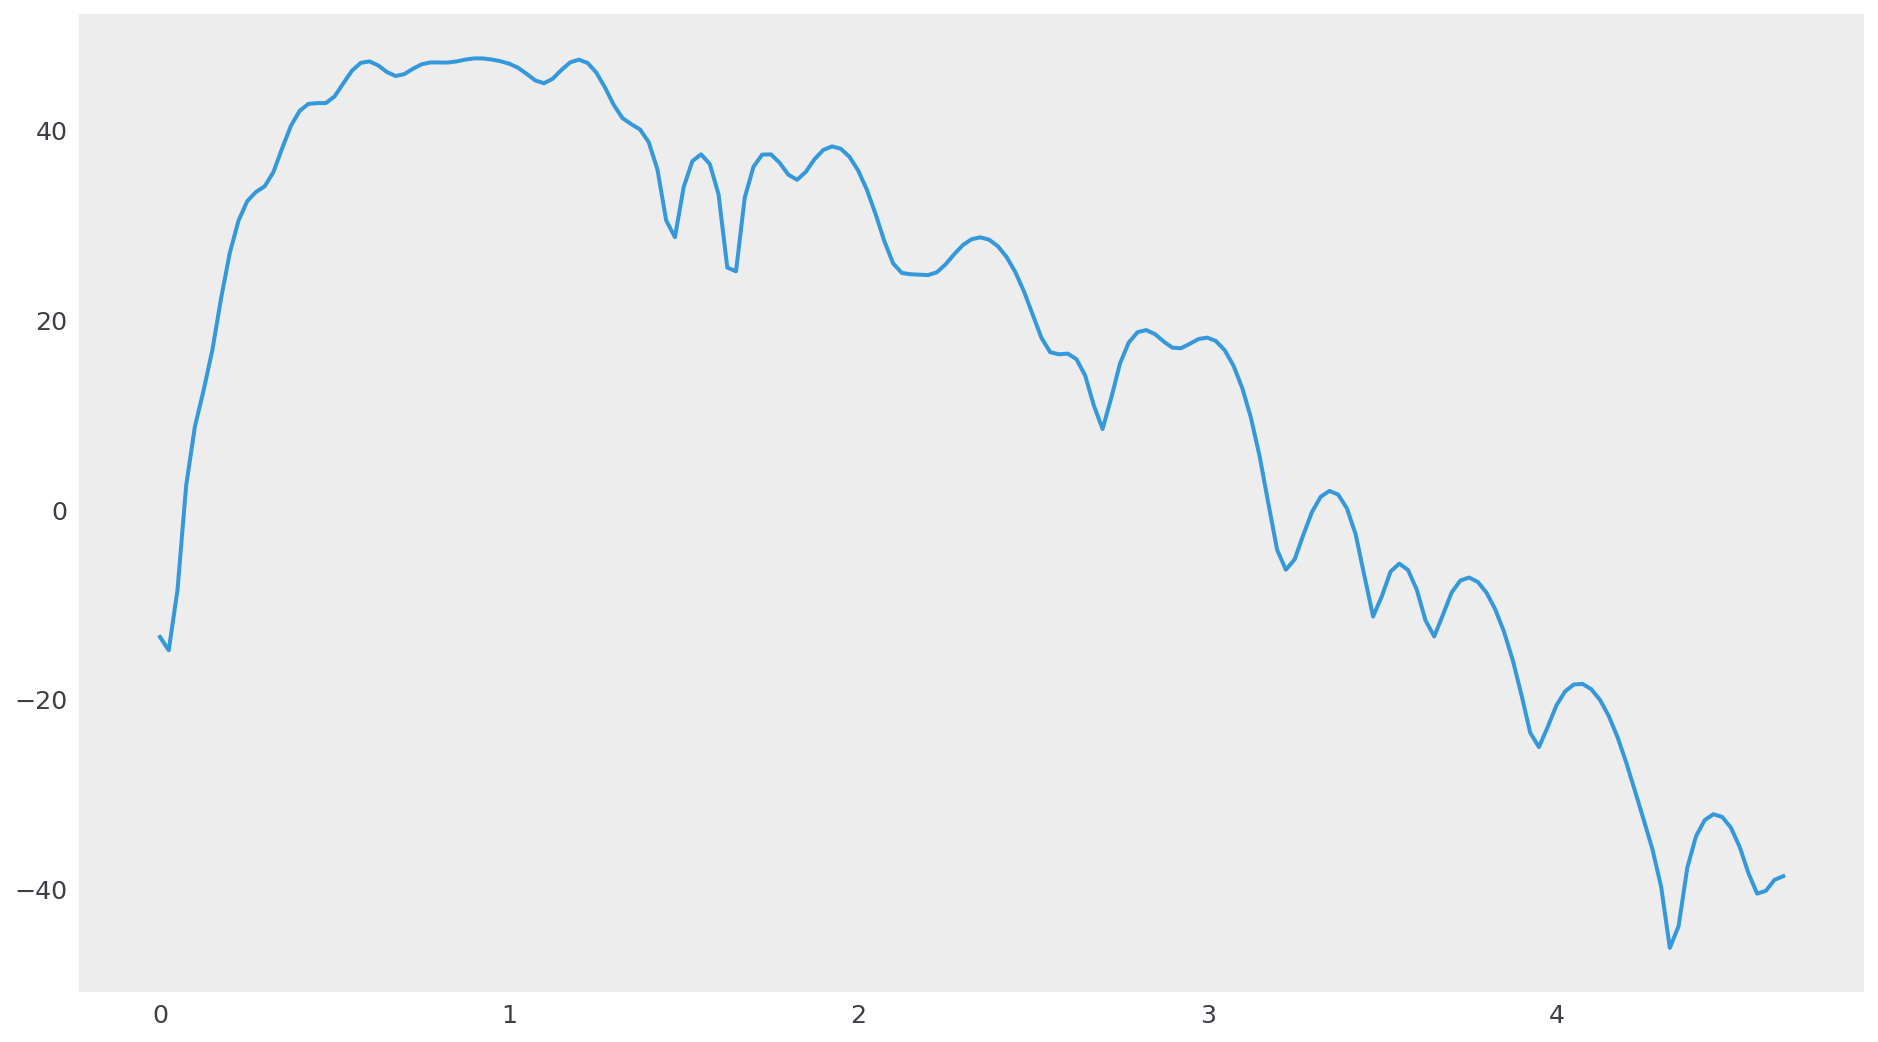

In [31]:
n_fft = n_samples
sampling_freq = 1. / (sampling_period)
df = sampling_freq / n_fft
freq = [df*i / 1e9 for i in range(0, n_fft)] 
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111);
raw_spectrum = get_spectrum(first_atom_mat, n_fft)
raw_spectrum_dB = to_dB(np.mean(raw_spectrum[0:n_fft//zoom_factor, :], axis=1))
ax.plot(freq[0:n_fft // zoom_factor], raw_spectrum_dB, color=ori_color, lw=2.0)

In [18]:
sampling_period

2.6680000222989442e-11

In [111]:
sar_dict_data = {}
sar_dict_data["sar_dict_mat"] = reshaped_sar_dict_mat
sar_dict_data["n_samples"] = n_samples
sar_dict_data["n_apertures"] = n_apertures
sar_dict_data["transmistted_pulse"] = transmitted_pulse
sar_dict_data["transmistted_pulse_sample_period"] = transmistted_pulse_sample_period
sar_dict_data["sampling_period"] = sampling_period

In [112]:
import pickle
saved_filename = mat_file_name + "_no_downsampling"
with open(os.path.join(DATA_PATH, saved_filename + ".pickle"), 'wb') as handle:
    pickle.dump(sar_dict_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
os.path.join(DATA_PATH, saved_filename + ".pickle")

In [ ]:
with open(os.path.join(DATA_PATH, saved_filename + ".pickle"), 'rb') as handle:
    b = pickle.load(handle)

<StemContainer object of 3 artists>

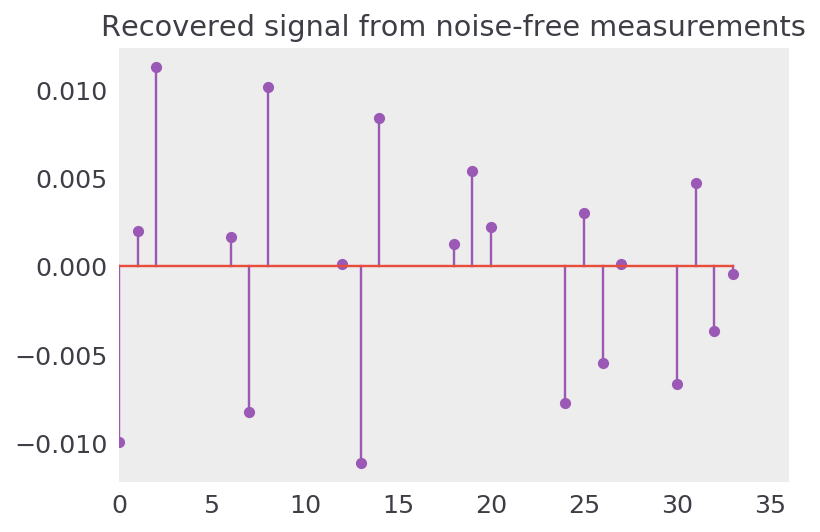

In [89]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
n_nonzero_coefs = 20
vectorized_one_chip = 1e4*calibrated_real_raw_data[:, 0:n_apertures].reshape(n_samples*n_apertures)
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(reshaped_sar_dict_mat, vectorized_one_chip)
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(1, 1, 1)
plt.xlim(0, n_atoms)
plt.stem(idx_r, coef[idx_r])

In [ ]:
reshaped_sar_dict_mat.shape
vectorized_one_trip.shape

In [41]:
real_ori_n_samples, real_ori_n_apertures = real_raw_data.shape
calibrated_real_raw_data = np.vstack((np.zeros((300, real_ori_n_apertures)), real_raw_data, np.zeros((600, real_ori_n_apertures))))

In [40]:
np.zeros((300, real_ori_n_apertures)).shape

(300, 1800)